In [ ]:
import pandas as pd
import word2vec
import matplotlib
import keras.optimizers as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
import model

# Make Dataset

In [ ]:
selected_frames = pd.read_json('data/selected_frames.json')
selected_frames = selected_frames[selected_frames.law.str.len() == 1]
selected_frames.loc[selected_frames.pos_title == '', 'pos_title'] = float('nan')
selected_frames.columns = pd.MultiIndex.from_product([['raw'], selected_frames.columns])

In [ ]:
selected_frames['data', 'Arg1'] = selected_frames.raw.pos_title.map(lambda x: next(zip(*x)), na_action='ignore').fillna('')
selected_frames['data', 'Arg2'] = selected_frames.raw.pos_content.map(lambda x: next(zip(*x)), na_action='ignore')
selected_frames['data', 'Relation'] = selected_frames.raw.law.map(lambda x: x[0])

for id, row in selected_frames.data.iterrows():
    for col in ['Arg1', 'Arg2']:
        selected_frames.loc[id, ('data', col)] = [word for word in row[col] if word != row.Relation]

In [272]:
selected_frames.data.head()

,Arg1,Arg2,Relation
0,[],"[七, 年前, ，, 年, 僅, 九, 歲, 及, 八, 歲, 的, 板橋市, 某, 國小,...",殺人罪
1,"[0, ‧, 3, 坪, 喊價, 800萬, 畸零地, 圍籬, 阻, 路, 拆, ！]","[○, ．, 三, 坪, 畸零地, 能, 「, 螞蟻, 吃, 大象, 」, ？, 北市, 議...",道路交通管理處罰條例
2,"[100, cc, 催芽劑奪, 信義, 鄉四, 命]","[信義, 鄉民, 朱明福, ，, 涉嫌, 將, 催芽劑, 摻入, 米酒, ，, 導致, 前,...",殺人罪
3,"[101, 前董座, 林鴻明, 二審, 輕, 判, 1年, 8月]","[前, 台北, 101, 董事長, 林鴻明, ，, 被, 控, 掏空, 股票, 上市, 的,...",證券交易法
4,"[101, 大樓, 前添, 紛爭, 台獨, 大, 旗, 砸傷, 人]","[台北, 101, 大樓, 前, 法輪, 功, 、, 愛國, 同心, 會, 的, 爭端, ，...",傷害罪


In [ ]:
selected_frames.data.Arg2.str.len().rename('Content Length').describe()

In [ ]:
trainset, validset = train_test_split(selected_frames, test_size=0.25, random_state=42)

In [273]:
relation = dataset.data.Relation.unique()
print('# Train set'.ljust(20), '%5d'%len(trainset))
print('# Valid set'.ljust(20), '%5d'%len(validset))
print('# Law'.ljust(20), '%5d'%len(relation))

# Train set           3016
# Valid set           1006
# Law                  274


# Word2Vec

In [ ]:
f_wordvec = 'data/wordvec.txt'

In [ ]:
corpus = trainset.data.Arg1.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None)
corpus = trainset.data.Arg2.map(' '.join, na_action='ignore')
corpus.dropna().to_csv('data/corpus.txt', index=None, mode='a')

In [ ]:
word2vec.word2vec('data/corpus.txt', f_wordvec, binary=0)
wordvec = word2vec.load(f_wordvec)
unk = wordvec.vectors.mean(0)
with open(f_wordvec, 'r+') as f:
    f.read()
    print('<unk>', *('%.6f'%x for x in unk), file=f)
    f.seek(0)
    vocab_size = next(int(n) for n in f.readline().split())
    vocab_size += 1
    f.seek(0)
    print(vocab_size, file=f, end='')

# Train

In [305]:
hist_names = dict(
    acc = ('acc', 'train'),
    val_acc = ('acc', 'valid'), 
    loss = ('loss', 'train'), 
    val_loss = ('loss', 'valid')
)
def record(hist):
    history = pd.DataFrame(hist.history, index=pd.Index(hist.epoch, name='epoch')).rename(columns=hist_names)
    history.columns = pd.MultiIndex.from_tuples(history.columns)
    
    print('Max Valid Acc Epoch')
    print(history[history.acc.valid == history.acc.valid.max()])
    history.acc.plot(title='Accuracy')
    history.loss.plot(title='Loss')

## CNN

In [ ]:
classifier = model.CNN(maxlen=450, torel=relation)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
classifier.compile(loss='categorical_crossentropy',
                   optimizer='RMSprop',
                   metrics=['acc'])
classifier.reset()
hist = classifier.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
43     0.953581  0.206116  0.543738  2.816923


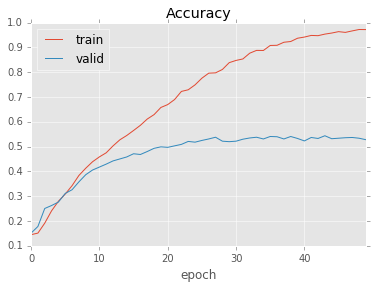

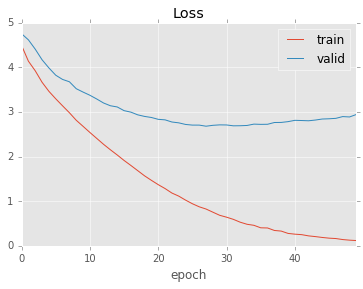

In [306]:
record(hist)

## Residue

In [ ]:
res = model.CNN(maxlen=450, torel=relation, residue=True, filter=100)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
res.compile(loss='categorical_crossentropy',
            optimizer='RMSprop',
            metrics=['acc'])
res.reset()
hist_res = res.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
44     0.936671  0.295464  0.572565  2.552134


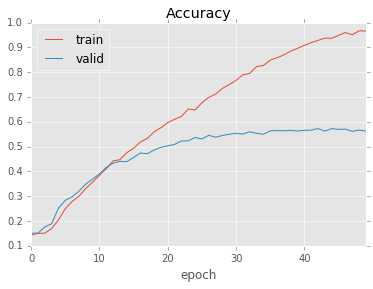

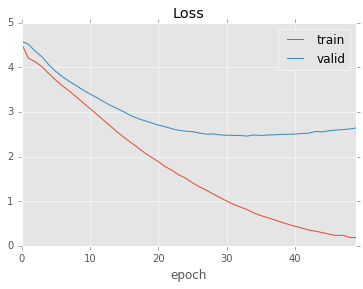

In [307]:
record(hist_res)

## Add CNN layers

In [ ]:
resl4 = model.CNN(maxlen=450, torel=relation, residue=True, filter=25, n_layers=4)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
resl4.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['acc'])
resl4.reset()
hist_resl4 = resl4.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc      loss       acc      loss
          train     train     valid     valid
epoch                                        
40     0.758621  0.931391  0.486083  3.457762


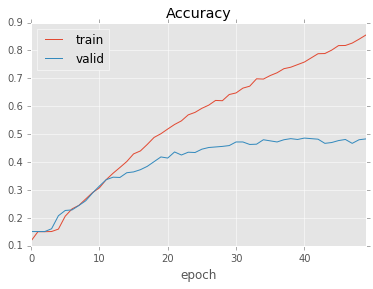

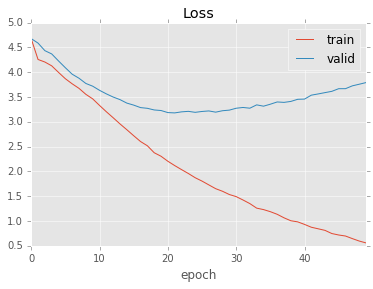

In [308]:
record(hist_resl4)

## Add Dense layers

In [310]:
resden = model.CNN(maxlen=450, torel=relation, residue=True, dense_layers=100, filter=100)

In [ ]:
# opt = optim.RMSprop(lr=1.2e-3)
resden.compile(loss='categorical_crossentropy',
               optimizer='RMSprop',
               metrics=['acc'])
resden.reset()
hist_resden = resden.fit(trainset, validset, epochs=50, batch_size=128)

Max Valid Acc Epoch
            acc     loss       acc      loss
          train    train     valid     valid
epoch                                       
39     0.869032  0.53962  0.571571  2.690347


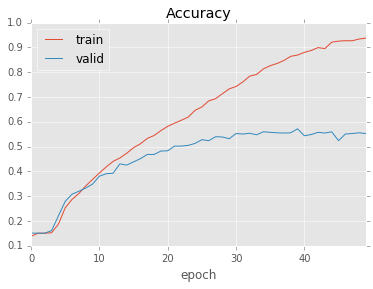

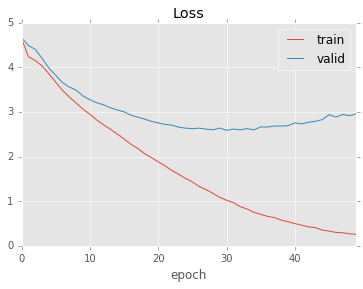

In [312]:
record(hist_resden)